# Time Series Analysis: bike accidents, locations, and gender information

## Prepping the Data

In [57]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
all_bike_accidents = pd.read_csv("all_bike_accidents.csv")
display(all_bike_accidents)

,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,...,prof,pr,pr1,plan,lartpc,larrout,surf,infra,situ,vma
0,201900000037,29,11,2019,0 days 13:40:00,1,67,67482,2,1,...,1,0,0,1,NaN,NaN,2,4,6,50
1,201900000037,29,11,2019,0 days 13:40:00,1,67,67482,2,1,...,1,0,0,1,NaN,NaN,2,4,6,50
2,201900000038,29,11,2019,0 days 13:50:00,1,66,66136,2,1,...,1,0,0,1,NaN,NaN,1,0,1,30
3,201900000038,29,11,2019,0 days 13:50:00,1,66,66136,2,1,...,1,0,0,1,NaN,NaN,1,0,1,30
4,201900000049,28,11,2019,0 days 08:16:00,1,49,49007,2,1,...,1,0,0,1,NaN,NaN,1,0,1,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38802,202200055252,7,5,2022,0 days 12:50:00,1,85,85201,1,1,...,3,(1),(1),1,NaN,-1,1,0,1,80
38803,202200055263,19,4,2022,0 days 16:30:00,1,30,30223,1,3,...,1,7,343,1,NaN,-1,1,0,1,70
38804,202200055263,19,4,2022,0 days 16:30:00,1,30,30223,1,3,...,1,7,343,1,NaN,-1,1,0,1,70
38805,202200055263,19,4,2022,0 days 16:30:00,1,30,30223,1,3,...,1,7,343,1,NaN,-1,1,0,1,70


In [3]:
#Reformating date & time

# Combine 'jour', 'mois', and 'an' into a single 'Date' column
date_components = all_bike_accidents[['an', 'mois', 'jour']].astype(str).apply(lambda x: '-'.join(x), axis=1)
all_bike_accidents['Date'] = pd.to_datetime(date_components, format='%Y-%m-%d')

# Extract time component from 'hrmn' timedelta and convert it to datetime
all_bike_accidents['Time'] = all_bike_accidents['hrmn'].astype(str).str.split().str[-1]
all_bike_accidents['Time'] = pd.to_datetime(all_bike_accidents['Time'], format='%H:%M:%S').dt.time

# Drop the original date and time columns if needed
all_bike_accidents.drop(columns=['jour', 'mois', 'an', 'hrmn'], inplace=True)

print(all_bike_accidents.head())

        Num_Acc  lum dep    com  agg  int  atm  col                      adr  \
0  201900000037    1  67  67482    2    1    2    3     JEAN JAURES (AVENUE)   
1  201900000037    1  67  67482    2    1    2    3     JEAN JAURES (AVENUE)   
2  201900000038    1  66  66136    2    1    1    6      MOULIN (PLACE JEAN)   
3  201900000038    1  66  66136    2    1    1    6      MOULIN (PLACE JEAN)   
4  201900000049    1  49  49007    2    1    1    7  TURPIN DE CRISSE AVENUE   

          lat  ... pr1 plan lartpc  larrout  surf  infra  situ  vma  \
0  48,5708480  ...   0    1    NaN      NaN     2      4     6   50   
1  48,5708480  ...   0    1    NaN      NaN     2      4     6   50   
2  42,6969500  ...   0    1    NaN      NaN     1      0     1   30   
3  42,6969500  ...   0    1    NaN      NaN     1      0     1   30   
4  47,4653400  ...   0    1    NaN      NaN     1      0     1   60   

        Date      Time  
0 2019-11-29  13:40:00  
1 2019-11-29  13:40:00  
2 2019-11-29  13:

In [5]:
# Filtering data by French Department (dep) to include only data for Ile-de-France

iledefrance_departments = ['75', '77', '78', '91', '92', '93', '94', '95']  # Île-de-France department numbers as strings
all_bike_accidents_iledefrance = all_bike_accidents[all_bike_accidents['dep'].isin(iledefrance_departments) | all_bike_accidents['dep'].isnull()]

print(all_bike_accidents_iledefrance.head())


         Num_Acc  lum dep    com  agg  int  atm  col  \
34  201900000218    1  77  77430    2    6    1    3   
35  201900000218    1  77  77430    2    6    1    3   
36  201900000220    1  77  77317    2    4    7    1   
37  201900000220    1  77  77317    2    4    7    1   
38  201900000224    1  78  78548    1    1    1    3   

                                   adr         lat  ...  pr1 plan lartpc  \
34              D9E1 X RUE DE LA MARNE  49,0716100  ...  118    1    NaN   
35              D9E1 X RUE DE LA MARNE  49,0716100  ...  118    1    NaN   
36  RUE D'ANDREZEL/rue des GUIGNEVEAUX  48,6092150  ...  (1)    1    NaN   
37  RUE D'ANDREZEL/rue des GUIGNEVEAUX  48,6092150  ...  (1)    1    NaN   
38                                 D91  48,7150440  ...  210    1    NaN   

    larrout  surf  infra  situ  vma       Date      Time  
34      NaN     1      5     1   50 2019-02-16  17:10:00  
35      NaN     1      5     1   50 2019-02-16  17:10:00  
36      NaN     1      0     

In [ ]:
#Dropping unneded columns
columns_to_drop = ['dep', 'com', 'agg', 'int', 'col', 'adr', 'voie', 'v1', 'v2', 'circ', 'nbv', 'prof', 'pr', 'pr1', 'plan', 'lartpc', 'larrout', 'surf', 'infra', 'senc', 'catv', 'obs', 'obsm', 'choc', 'manv', 'occutc', 'place', 'catu', 'locp', 'actp', 'etatp']
all_bike_accidents_iledefrance.drop(columns=columns_to_drop, inplace=True)

In [8]:
display(all_bike_accidents_iledefrance.head())

,Num_Acc,lum,atm,lat,long,id_vehicule_x,num_veh_x,grav,sexe,an_nais,...,secu3,id_vehicule_y,num_veh_y,motor,catr,vosp,situ,vma,Date,Time
34,201900000218,1,1,"49,0716100","2,8051200",138 306 113,B01,3,1,1952.0,...,-1,138 306 113,B01,5,3,0,1,50,2019-02-16,17:10:00
35,201900000218,1,1,"49,0716100","2,8051200",138 306 114,A01,1,1,1967.0,...,-1,138 306 113,B01,5,3,0,1,50,2019-02-16,17:10:00
36,201900000220,1,7,"48,6092150","2,8869400",138 306 110,A01,1,1,1973.0,...,-1,138 306 111,B01,5,4,0,1,50,2019-02-15,16:40:00
37,201900000220,1,7,"48,6092150","2,8869400",138 306 111,B01,3,1,2007.0,...,-1,138 306 111,B01,5,4,0,1,50,2019-02-15,16:40:00
38,201900000224,1,1,"48,7150440","2,0019880",138 306 102,B01,4,1,1990.0,...,-1,138 306 103,A01,5,3,0,1,80,2019-02-16,14:43:00


In [10]:
# Spliting the data into training set and test set

training_years = all_bike_accidents_iledefrance[(all_bike_accidents_iledefrance['Date'].dt.year >= 2019) & (all_bike_accidents_iledefrance['Date'].dt.year <= 2021)]
test_year = all_bike_accidents_iledefrance[all_bike_accidents_iledefrance['Date'].dt.year == 2022]

print("Training Years:")
display(training_years.head())
print("\nTest Year:")
display(test_year.head())

Training Years:


,Num_Acc,lum,atm,lat,long,id_vehicule_x,num_veh_x,grav,sexe,an_nais,...,secu3,id_vehicule_y,num_veh_y,motor,catr,vosp,situ,vma,Date,Time
34,201900000218,1,1,"49,0716100","2,8051200",138 306 113,B01,3,1,1952.0,...,-1,138 306 113,B01,5,3,0,1,50,2019-02-16,17:10:00
35,201900000218,1,1,"49,0716100","2,8051200",138 306 114,A01,1,1,1967.0,...,-1,138 306 113,B01,5,3,0,1,50,2019-02-16,17:10:00
36,201900000220,1,7,"48,6092150","2,8869400",138 306 110,A01,1,1,1973.0,...,-1,138 306 111,B01,5,4,0,1,50,2019-02-15,16:40:00
37,201900000220,1,7,"48,6092150","2,8869400",138 306 111,B01,3,1,2007.0,...,-1,138 306 111,B01,5,4,0,1,50,2019-02-15,16:40:00
38,201900000224,1,1,"48,7150440","2,0019880",138 306 102,B01,4,1,1990.0,...,-1,138 306 103,A01,5,3,0,1,80,2019-02-16,14:43:00



Test Year:


,Num_Acc,lum,atm,lat,long,id_vehicule_x,num_veh_x,grav,sexe,an_nais,...,secu3,id_vehicule_y,num_veh_y,motor,catr,vosp,situ,vma,Date,Time
28731,202200000016,1,1,"48,8479990000","2,3301760000",813 926,A01,1,2,1960.0,...,-1,813 927,B01,5,4,0,1,30,2022-10-21,16:32:00
28732,202200000016,1,1,"48,8479990000","2,3301760000",813 927,B01,4,1,1982.0,...,-1,813 927,B01,5,4,0,1,30,2022-10-21,16:32:00
28733,202200000017,1,1,"48,8513870000","2,3431860000",813 924,A01,1,1,2002.0,...,-1,813 925,B01,5,4,1,5,30,2022-10-20,13:00:00
28734,202200000017,1,1,"48,8513870000","2,3431860000",813 925,B01,4,1,2003.0,...,-1,813 925,B01,5,4,1,5,30,2022-10-20,13:00:00
28735,202200000025,1,1,"48,8210280000","2,3545150000",813 913,A01,3,1,1961.0,...,-1,813 913,A01,5,4,1,5,50,2022-10-21,11:25:00


In [11]:
print(training_years)

            Num_Acc  lum  atm            lat          long id_vehicule_x  \
34     201900000218    1    1     49,0716100     2,8051200   138 306 113   
35     201900000218    1    1     49,0716100     2,8051200   138 306 114   
36     201900000220    1    7     48,6092150     2,8869400   138 306 110   
37     201900000220    1    7     48,6092150     2,8869400   138 306 111   
38     201900000224    1    1     48,7150440     2,0019880   138 306 102   
...             ...  ...  ...            ...           ...           ...   
28713  202100056290    2    1  48,8874996701  2,4103069848       101 279   
28722  202100056346    5    1  48,8104900000  2,3619400000       101 181   
28723  202100056346    5    1  48,8104900000  2,3619400000       101 181   
28728  202100056424    1    8  48,8769050000  2,3665940000       101 040   
28729  202100056424    1    8  48,8769050000  2,3665940000       101 041   

      num_veh_x  grav  sexe  an_nais  ...  secu3  id_vehicule_y  num_veh_y  \
34       

In [17]:
# Setting date column as the index of the two dfs
training_years.set_index('Date', inplace=True)
test_year.set_index('Date', inplace=True)

## Testing Models

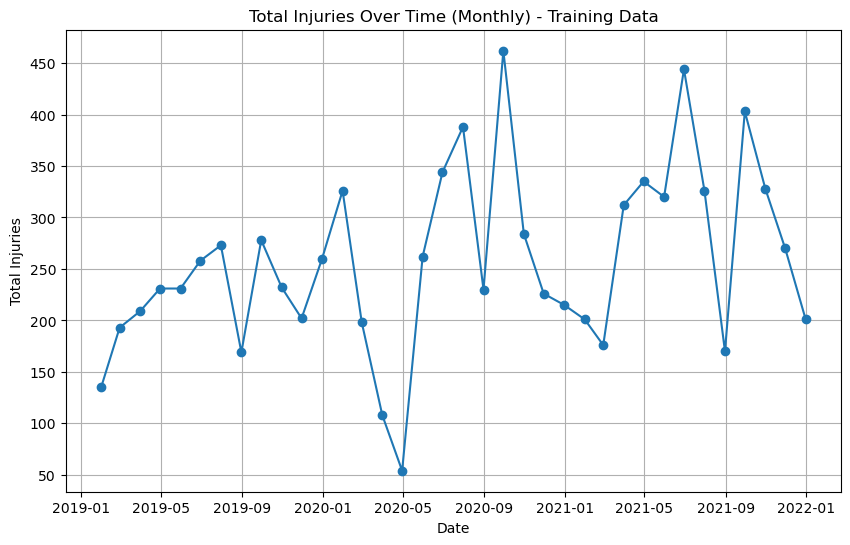

c:\Users\darce\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\darce\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\darce\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\darce\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\darce\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too fe

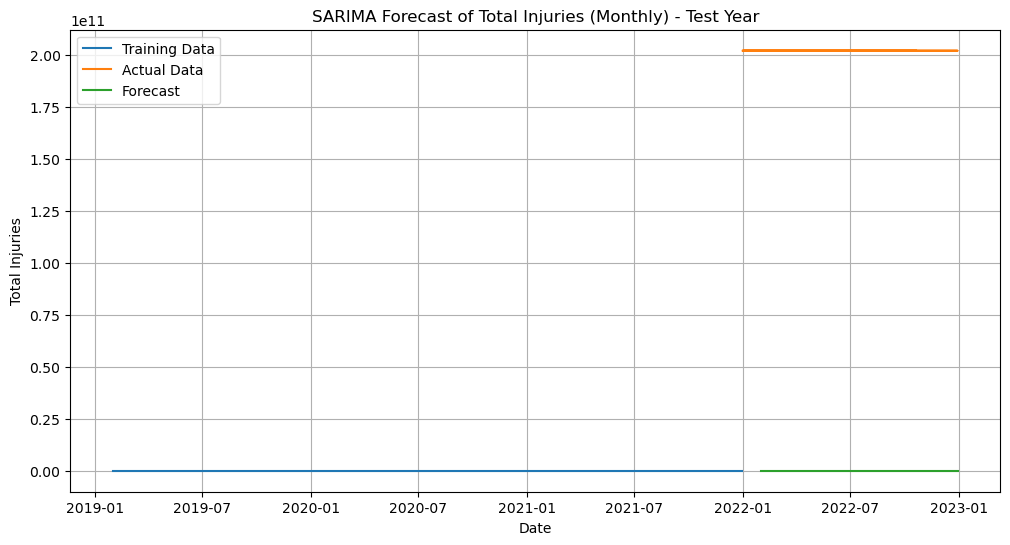

In [24]:
# Aggregate training data by monthly time periods
training_monthly_aggregated = training_years.resample('M').size().reset_index(name='Total_Injuries')

# Set 'Date' column as index
training_monthly_aggregated.set_index('Date', inplace=True)

# Visualize the aggregated training data
plt.figure(figsize=(10, 6))
plt.plot(training_monthly_aggregated.index, training_monthly_aggregated['Total_Injuries'], marker='o', linestyle='-')
plt.title('Total Injuries Over Time (Monthly) - Training Data')
plt.xlabel('Date')
plt.ylabel('Total Injuries')
plt.grid(True)
plt.show()

# Fit SARIMA model to the aggregated training data
sarima_model = SARIMAX(training_monthly_aggregated['Total_Injuries'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

# Make predictions for the test year
start_date = test_year.index.min()
end_date = test_year.index.max()
forecast = sarima_result.predict(start=start_date, end=end_date, dynamic=False)

# Plot the forecast for the test year
plt.figure(figsize=(12, 6))
plt.plot(training_monthly_aggregated.index, training_monthly_aggregated['Total_Injuries'], label='Training Data')
plt.plot(test_year.index, test_year['Num_Acc'], label='Actual Data')
plt.plot(forecast.index, forecast, label='Forecast')
plt.title('SARIMA Forecast of Total Injuries (Monthly) - Test Year')
plt.xlabel('Date')
plt.ylabel('Total Injuries')
plt.legend()
plt.grid(True)
plt.show()

#SARIMA doesn't work at all... I suspect that the seasonality of the data will necessitate another approach.

In [33]:
# Check that the index to datetime if it's not already datetime
training_years.index = pd.to_datetime(training_years.index)
test_year.index = pd.to_datetime(test_year.index)

# Concatenate index with the 'Time' column to create a new datetime column
training_years['Datetime'] = training_years.index + pd.to_timedelta(training_years['Time'].astype(str))
test_year['Datetime'] = test_year.index + pd.to_timedelta(test_year['Time'].astype(str))

# Drop the original "Time" column if it's no longer needed
training_years.drop(columns=['Time'], inplace=True)
test_year.drop(columns=['Time'], inplace=True)

C:\Users\darce\AppData\Local\Temp\ipykernel_4380\503184817.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_years['Datetime'] = training_years.index + pd.to_timedelta(training_years['Time'].astype(str))
C:\Users\darce\AppData\Local\Temp\ipykernel_4380\503184817.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_year['Datetime'] = test_year.index + pd.to_timedelta(test_year['Time'].astype(str))
C:\Users\darce\AppData\Local\Temp\ipykernel_4380\503184817.py:10: SettingWithCopyWarning: 
A valu

Did some research and discovered Prophet and Exponentiaal Smoothing.
Tried Prophet and could not get it installed.
Did more research on expopnential smoothing and found this:
Exponential Smoothing (ETS): ETS models, such as Holt-Winters, are simple exponential smoothing techniques that can capture trend and seasonality in time series data. They are relatively easy to implement and can be effective for forecasting.
- Since the data is definitely seasonal as I saw in the EDA, I decided to try ETS.

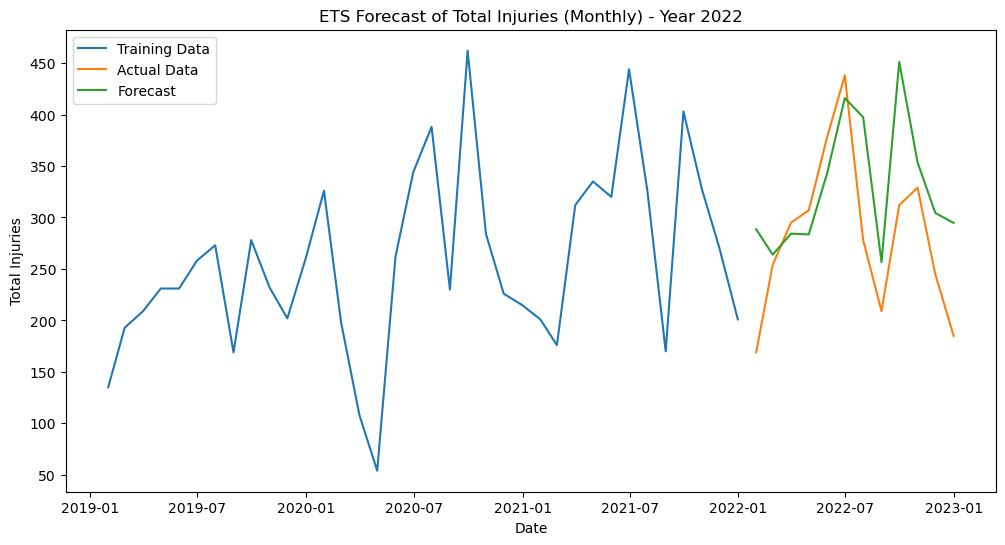

In [86]:
# Ensure 'Datetime' is already set as the index, if not, set it
if 'Datetime' not in training_years.columns:
    training_years.set_index('Datetime', inplace=True)
if 'Datetime' not in test_year.columns:
    test_year.set_index('Datetime', inplace=True)

# Aggregate 'Num_Acc' column by monthly time periods
training_monthly_aggregated = training_years['Num_Acc'].resample('M').count()

# Fit ETS model
ets_model = ExponentialSmoothing(training_monthly_aggregated, trend='add', seasonal='add', seasonal_periods=12)
ets_result = ets_model.fit()

# Make predictions for the year 2022
start_date_2022 = pd.to_datetime('2022-01-01')
end_date_2022 = pd.to_datetime('2022-12-31')
forecast = ets_result.predict(start=start_date_2022, end=end_date_2022)

# Aggregate the actual data by monthly time periods
test_year_monthly_aggregated = test_year['Num_Acc'].resample('M').count()

# Plot the forecast along with the aggregated actual data
plt.figure(figsize=(12, 6))
plt.plot(training_monthly_aggregated.index, training_monthly_aggregated, label='Training Data')
plt.plot(test_year_monthly_aggregated.index, test_year_monthly_aggregated, label='Actual Data')
plt.plot(pd.date_range(start=start_date_2022, end=end_date_2022, freq='M'), forecast, label='Forecast')
plt.title('ETS Forecast of Total Injuries (Monthly) - Year 2022')
plt.xlabel('Date')
plt.ylabel('Total Injuries')
plt.legend()
plt.show()


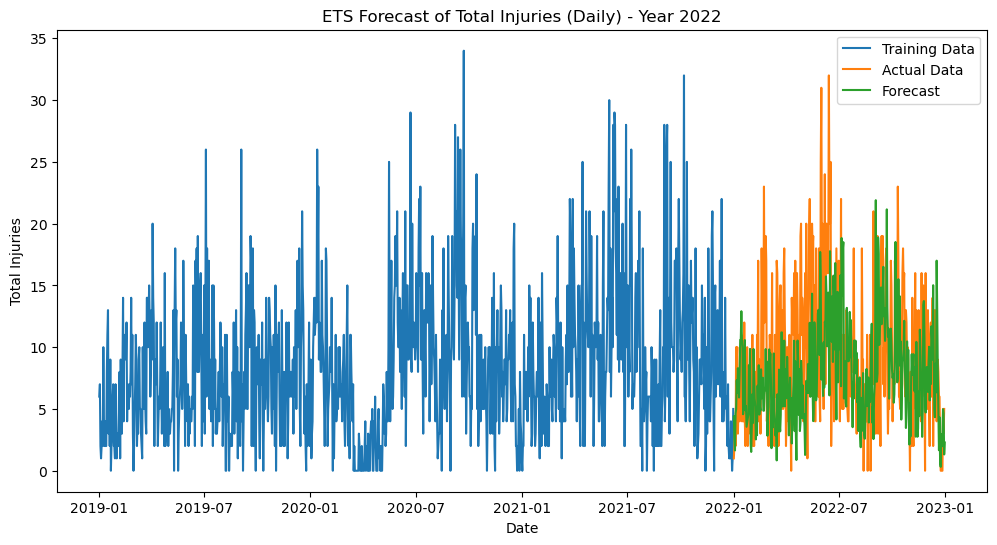

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Aggregate 'Num_Acc' column by daily time periods
training_daily_aggregated = training_years['Num_Acc'].resample('D').count()

# Fit ETS model
ets_model = ExponentialSmoothing(training_daily_aggregated, trend='add', seasonal='add', seasonal_periods=365)
ets_result = ets_model.fit()

# Make predictions for the year 2022
start_date_2022 = pd.to_datetime('2022-01-01')
end_date_2022 = pd.to_datetime('2022-12-31')
forecast = ets_result.predict(start=start_date_2022, end=end_date_2022)

# Aggregate the actual data by daily time periods
test_year_daily_aggregated = test_year['Num_Acc'].resample('D').count()

# Plot the forecast along with the aggregated actual data
plt.figure(figsize=(12, 6))
plt.plot(training_daily_aggregated.index, training_daily_aggregated, label='Training Data')
plt.plot(test_year_daily_aggregated.index, test_year_daily_aggregated, label='Actual Data')
plt.plot(pd.date_range(start=start_date_2022, end=end_date_2022, freq='D'), forecast, label='Forecast')
plt.title('ETS Forecast of Total Injuries (Daily) - Year 2022')
plt.xlabel('Date')
plt.ylabel('Total Injuries')
plt.legend()
plt.show()
()
plt.show()



In [82]:
print("Forecast start and end dates:", forecast.index.min(), forecast.index.max())
print("Actual data start and end dates:", test_year_daily_aggregated.index.min(), test_year_daily_aggregated.index.max())

Forecast start and end dates: 2022-01-01 00:00:00 2022-12-31 00:00:00
Actual data start and end dates: 2022-01-01 00:00:00 2022-12-30 00:00:00


In [83]:
# Align forecast to the actual data's range
forecast_aligned = forecast.loc[test_year_daily_aggregated.index]

# Assessing the Accuracy of the Model

Daily Aggregated Accidents Forcasting

In [84]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    if np.any(non_zero):
        return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100
    else:
        return np.nan  

In [85]:
mae = mean_absolute_error(test_year_daily_aggregated, forecast_aligned)
mse = mean_squared_error(test_year_daily_aggregated, forecast_aligned)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_year_daily_aggregated, forecast_aligned)

# Print the metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Absolute Error (MAE): 5.111760914301039
Mean Squared Error (MSE): 42.415057290836046
Root Mean Squared Error (RMSE): 6.512684338338229
Mean Absolute Percentage Error (MAPE): 70.54296801207083
